# Problem 2:
Forecast the CocaCola prices passengers data set. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for forecasting.

## 1. Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
# ACF and PACF plots.
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
# Time series decomposition plot.
from statsmodels.tsa.seasonal import seasonal_decompose

# Linear model:
import statsmodels.formula.api as smf

# Smoothing based models
## Simple exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
## Holt model
from statsmodels.tsa.holtwinters import Holt
## Holts winter exponential smoothing with multiplicative seasonality and additive trend
from statsmodels.tsa.holtwinters import ExponentialSmoothing  # three levels of smoothening

# ARMA model
from statsmodels.tsa.arima_model import ARMA
# ARIMA model
from statsmodels.tsa.arima_model import ARIMA

# Evaluation metrics
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

## 2. Load data

In [4]:
coke_df = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')

In [5]:
coke_df.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


## 3. EDA

### 3.1 Data understanding

In [6]:
coke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [7]:
coke_df1 = coke_df.copy()

In [8]:
coke_df1.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


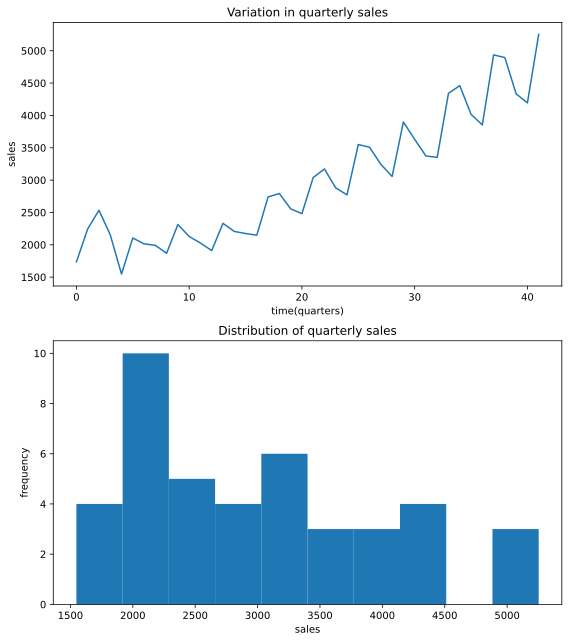

In [9]:
fig, ax = plt.subplots(2,1, figsize=(8,9))
ax[0].plot(coke_df1['Sales'])
ax[0].set_title('Variation in quarterly sales')
ax[0].set_xlabel('time(quarters)')
ax[0].set_ylabel('sales')

ax[1].hist(coke_df1['Sales'])
ax[1].set_title('Distribution of quarterly sales')
ax[1].set_xlabel('sales')
ax[1].set_ylabel('frequency')

fig.tight_layout()
plt.show()

In [10]:
# Summary statistics:
coke_df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,42.0,2994.353308,977.930896,1547.818996,2159.714247,2782.376999,3609.25,5253.0


### 3.2 Data preparation

In [11]:
# Sales and log(sales)
coke_df1['log_Sales'] = coke_df1['Sales'].apply(lambda x:np.log(x))

In [12]:
# Split quarters from the year and put them into separate columns.
coke_df1[['Q', 'year']] = coke_df1['Quarter'].str.split('_', expand=True) # Using vectorized str split.

In [13]:
# Add a prefix of '19' to the year column.
coke_df1['year'] = coke_df1['year'].apply(lambda x: '19'+ str(x))

In [14]:
# One hot encode the quarters.
quarters = coke_df1['Q'].unique()

In [15]:
quat_enc = pd.get_dummies(coke_df1['Q']).reindex(columns=quarters)

In [16]:
quat_enc.head()

,Q1,Q2,Q3,Q4
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,1,0,0,0


In [17]:
# Creating numeric columns for time (in terms of quarters)
t_array = np.linspace(1, len(coke_df1), num =len(coke_df1), dtype=int)
t_sq_array = t_array**2

In [18]:
time = {'t': t_array,
       't_square':t_sq_array}

In [19]:
t_df = pd.DataFrame(time, index=coke_df1.index)

In [20]:
coke_df2 = pd.concat([coke_df1, t_df, quat_enc], axis=1)

In [21]:
coke_df2.head()

,Quarter,Sales,log_Sales,Q,year,t,t_square,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,7.458663,Q1,1986,1,1,1,0,0,0
1,Q2_86,2244.960999,7.716443,Q2,1986,2,4,0,1,0,0
2,Q3_86,2533.804993,7.837477,Q3,1986,3,9,0,0,1,0
3,Q4_86,2154.962997,7.675529,Q4,1986,4,16,0,0,0,1
4,Q1_87,1547.818996,7.344602,Q1,1987,5,25,1,0,0,0


### 3.3 Visualization - Heatmap and boxplots.

In [22]:
# Crosstab to generate heatmaps
coke_pivot = pd.pivot_table(data=coke_df2,
                            values='Sales',
                            index='year',
                            columns='Q',).fillna(0)

In [23]:
coke_pivot

Q,Q1,Q2,Q3,Q4
year,,,,
1986,1734.827000,2244.960999,2533.804993,2154.962997
1987,1547.818996,2104.411995,2014.362999,1991.746998
1988,1869.049999,2313.631996,2128.320000,2026.828999
1989,1910.603996,2331.164993,2206.549995,2173.967995
1990,2148.278000,2739.307999,2792.753998,2556.009995
1991,2480.973999,3039.522995,3172.115997,2879.000999
1992,2772.000000,3550.000000,3508.000000,3243.859993
1993,3056.000000,3899.000000,3629.000000,3373.000000
1994,3352.000000,4342.000000,4461.000000,4017.000000


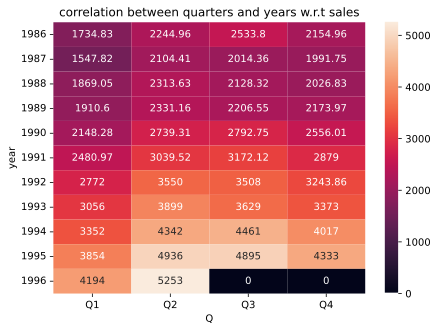

In [24]:
### Heatmap:
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(data=coke_pivot, annot=True, fmt='g', ax=ax)
ax.set_title('correlation between quarters and years w.r.t sales')
plt.show()

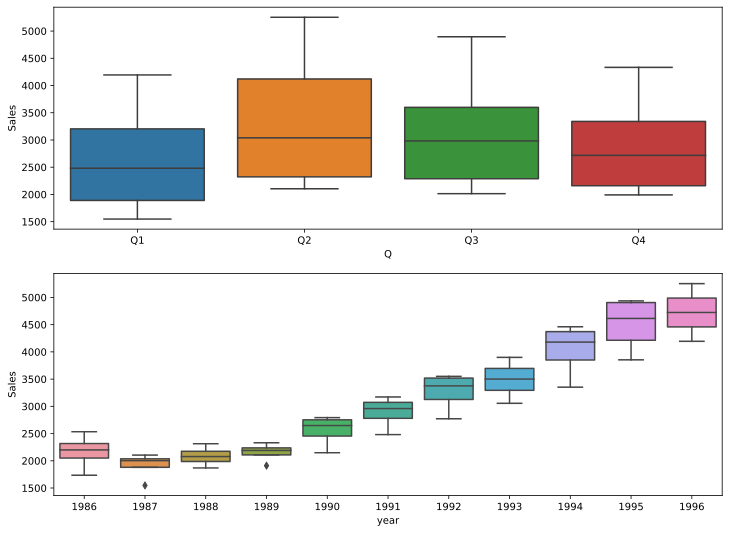

In [25]:
# Boxplot (yearwise and quarterwise)
fig, ax = plt.subplots(2, 1, figsize=(12,9))
sns.boxplot(x='Q', y='Sales', data=coke_df2, ax=ax[0])
sns.boxplot(x='year', y='Sales', data=coke_df2, ax=ax[1])
plt.show()

### 3.4 Visualizing the trend with line plot

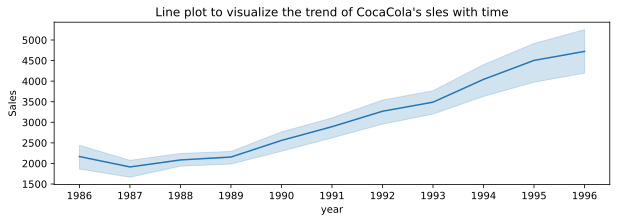

In [26]:
# Lineplot:
fig, ax = plt.subplots(figsize=(10,3))
sns.lineplot(x='year', y='Sales', data=coke_df2, ax=ax)
ax.set_title('Line plot to visualize the trend of CocaCola\'s sles with time')
plt.show()

### 3.5 Lag plot
Visualizing relationship of previous month's number with next months number of passengers

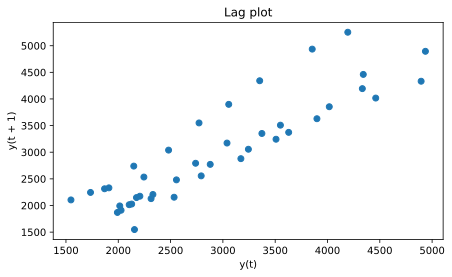

In [27]:
fig, ax = plt.subplots()
pd.plotting.lag_plot(coke_df2['Sales'], ax=ax)
ax.set_title('Lag plot')
plt.show()

**Observations**: The linear trend indicates that there is a relationship between previous month's passenger count with the next month's count 

### 3.6 Time series decomposition plot

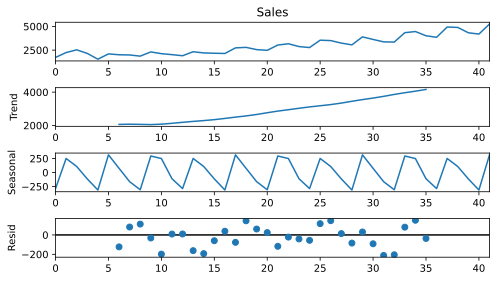

In [28]:
decompose_ts_add = seasonal_decompose(coke_df2['Sales'],period=12)
decompose_ts_add.plot()
plt.show()

### 3.4 Observations:
- Original dataset: 42 recors and 2 columns, no null values.
- The slaes distribution is skewed. The mean and variance changes every year.
- The sales range form ~1548 - 5253 (in monetary units).
- From the lineplots, we see a rise in the sales over time except for a slight dip during 1986 - 1988. This is also evident form the yearwise boxplots.
- form the quarterly boxplot, and heatmap we find that slaes are at the lowest in Q1, it picku up and peaks during Q2 and comes down during Q3 and Q4.
- A linear or exponential model may perform well for forecasting the sales.

## 4. Model based forecasting 

### 4.1 Model building

In [29]:
coke_df2.head()

,Quarter,Sales,log_Sales,Q,year,t,t_square,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,7.458663,Q1,1986,1,1,1,0,0,0
1,Q2_86,2244.960999,7.716443,Q2,1986,2,4,0,1,0,0
2,Q3_86,2533.804993,7.837477,Q3,1986,3,9,0,0,1,0
3,Q4_86,2154.962997,7.675529,Q4,1986,4,16,0,0,0,1
4,Q1_87,1547.818996,7.344602,Q1,1987,5,25,1,0,0,0


In [30]:
coke_df2.shape

(42, 11)

In [31]:
train_data = coke_df2.iloc[: 32, :]

In [32]:
test_data = coke_df2.iloc[32: , :]

In [33]:
# Function to construct formula for ols
def formula_constructor(predict_col, feature_names):
    formula = predict_col + '~'
    for i in range(len(feature_names)):
        if i == 0:
            formula += feature_names[i]
        else:
            formula += ('+' + feature_names[i])
    return formula

In [34]:
# Function to train and test different time series models.
def time_series_model(train_data, test_data, feature_names, predict_col, log_predict_col=None, exp=False, model_name=None, disp_results=False):
    
    if exp == True:
        # Training
        formula = formula_constructor(log_predict_col, feature_names)
        model = smf.ols(formula, data=train_data).fit()
        preds = pd.Series(model.predict(pd.DataFrame(test_data[feature_names])))
        # Evaluation:
        rmse = np.sqrt(np.mean((np.array(test_data[predict_col]) - np.array(np.exp(preds)))**2))
    else:
        # Training
        formula = formula_constructor(predict_col, feature_names)
        model = smf.ols(formula, data=train_data).fit() 
        preds = pd.Series(model.predict(pd.DataFrame(test_data[feature_names])))
        # Evaluation:
        rmse = np.sqrt(np.mean((np.array(test_data[predict_col]) - np.array(preds))**2))
    
    if disp_results == True: 
        print("Formula used for {} model: {}".format(model_name, formula))
        print("RMSE for {} model        : {:.3f}".format(model_name, rmse))
        return rmse
    else:
        return rmse

#### 4.1.1 Linear model

In [35]:
lin_mod = time_series_model(train_data=train_data,
                            test_data=test_data,
                            feature_names='t',
                            predict_col='Sales',
                            exp=False,
                            model_name='linear',
                            disp_results=True)

Formula used for linear model: Sales~t
RMSE for linear model        : 752.923


#### 4.1.2 Exponential model

In [36]:
exp_model = time_series_model(train_data=train_data,
                              test_data=test_data,
                              feature_names='t',
                              predict_col='Sales',
                              log_predict_col='log_Sales',
                              exp=True,
                              model_name='exponential',
                              disp_results=True)

Formula used for exponential model: log_Sales~t
RMSE for exponential model        : 590.332


#### 4.1.3 Quadratic model

In [37]:
quad_model = time_series_model(train_data=train_data,
                               test_data=test_data,
                               feature_names=['t', 't_square'],
                               predict_col='Sales',
                               log_predict_col=None,
                               exp=False,
                               model_name='quadratic',
                               disp_results=True)

Formula used for quadratic model: Sales~t+t_square
RMSE for quadratic model        : 457.736


#### 4.1.4 Additive seasonality 

In [38]:
add_sea = time_series_model(train_data=train_data,
                            test_data=test_data,
                            feature_names=['Q1', 'Q2', 'Q3', 'Q4'],
                            predict_col='Sales',
                            log_predict_col=None,
                            exp=False,
                            model_name='additive seasonality',
                            disp_results=True)

Formula used for additive seasonality model: Sales~Q1+Q2+Q3+Q4
RMSE for additive seasonality model        : 1850.467


#### 4.1.5 Additive seasonality quadratic

In [39]:
add_sea_quad = time_series_model(train_data=train_data,
                                test_data=test_data,
                                feature_names=['t', 't_square', 'Q1', 'Q2', 'Q3', 'Q4'],
                                predict_col='Sales',
                                log_predict_col=None,
                                exp=False,
                                model_name='additive seasonality quadratic',
                                disp_results=True)

Formula used for additive seasonality quadratic model: Sales~t+t_square+Q1+Q2+Q3+Q4
RMSE for additive seasonality quadratic model        : 277.351


#### 4.1.6 Multiplicative seasonality:

In [40]:
mul_sea = time_series_model(train_data=train_data,
                            test_data=test_data,
                            feature_names=['Q1', 'Q2', 'Q3', 'Q4'],
                            predict_col='Sales',
                            log_predict_col='log_Sales',
                            exp=True,
                            model_name='multiplicative seasonality',
                            disp_results=True) 

Formula used for multiplicative seasonality model: log_Sales~Q1+Q2+Q3+Q4
RMSE for multiplicative seasonality model        : 1908.250


### 4.2 Compare the results

In [41]:
summary = {'Model RMSE':pd.Series(['linear', 'exponential', 'quadratic', 'add_seasonality', 'add_seasonality_quad', 'mul_seasonality']),
           'RMSE values':pd.Series([lin_mod, exp_model, quad_model, add_sea, add_sea_quad, mul_sea])}
table_rmse = pd.DataFrame(summary).sort_values(['RMSE values']).reset_index(drop=True)

In [42]:
table_rmse

,Model RMSE,RMSE values
0,add_seasonality_quad,277.351077
1,quadratic,457.735736
2,exponential,590.331643
3,linear,752.923393
4,add_seasonality,1850.466546
5,mul_seasonality,1908.250395


### 4.3 Observations:
- From the above analysis, we see that 'additive seasonality with quadratic trend' has the least RMSE od all the models, thus we can use it for forecasting.
- 9 dummy variables were created for providing a forecast on the airlines' potential number of passengers.

### 4.4 Model fitting and verification

In [43]:
feature_cols = ['t', 't_square', 'Q1', 'Q2', 'Q3', 'Q4']
predict_col = 'Sales'

In [44]:
formula = formula_constructor(predict_col, feature_cols)
add_seaq_model = smf.ols(formula, data=train_data).fit() 

In [45]:
test_data1 = test_data.copy() # To use for predictions

In [46]:
test_data1 = test_data1.drop(['Sales', 'log_Sales'], axis=1)

In [47]:
test_data1['F_Sales'] = pd.Series(add_seaq_model.predict(pd.DataFrame(test_data[feature_cols])))

In [48]:
test_data1.head()

,Quarter,Q,year,t,t_square,Q1,Q2,Q3,Q4,F_Sales
32,Q1_94,Q1,1994,33,1089,1,0,0,0,3599.111165
33,Q2_94,Q2,1994,34,1156,0,1,0,0,4264.178607
34,Q3_94,Q3,1994,35,1225,0,0,1,0,4311.803302
35,Q4_94,Q4,1994,36,1296,0,0,0,1,4190.873370
36,Q1_95,Q1,1995,37,1369,1,0,0,0,4141.181850


### 4.5 Visualizing the sequential prediction

In [49]:
train_data1 = train_data.copy() # To use for visualizations

In [50]:
sales_forecast = pd.concat([train_data1, test_data1], axis=0)

In [51]:
sales_forecast.tail()

,Quarter,Sales,log_Sales,Q,year,t,t_square,Q1,Q2,Q3,Q4,F_Sales
37,Q2_95,NaN,NaN,Q2,1995,38,1444,0,1,0,0,4823.418475
38,Q3_95,NaN,NaN,Q3,1995,39,1521,0,0,1,0,4888.212351
39,Q4_95,NaN,NaN,Q4,1995,40,1600,0,0,0,1,4784.451601
40,Q1_96,NaN,NaN,Q1,1996,41,1681,1,0,0,0,4751.929264
41,Q2_96,NaN,NaN,Q2,1996,42,1764,0,1,0,0,5451.335070


In [52]:
sales_forecast_vis = sales_forecast[['Sales', 'F_Sales']]

In [53]:
sales_forecast_vis.tail()

,Sales,F_Sales
37,NaN,4823.418475
38,NaN,4888.212351
39,NaN,4784.451601
40,NaN,4751.929264
41,NaN,5451.335070


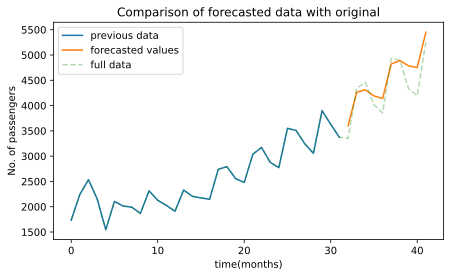

In [54]:
fig, ax = plt.subplots()
ax.plot(sales_forecast_vis, label=['previous data','forecasted values'])
ax.plot(range(len(sales_forecast_vis)), coke_df2['Sales'], 'g--', label='full data', alpha=0.3)
ax.set_xlabel('time(months)')
ax.set_ylabel('No. of passengers')
ax.set_title('Comparison of forecasted data with original')
ax.legend()
plt.show()

## 5 Data driven forecasting

### 5.1 Models based on smoothing 

#### 5.1.1 Moving average

In [55]:
coke_df2.head()

,Quarter,Sales,log_Sales,Q,year,t,t_square,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,7.458663,Q1,1986,1,1,1,0,0,0
1,Q2_86,2244.960999,7.716443,Q2,1986,2,4,0,1,0,0
2,Q3_86,2533.804993,7.837477,Q3,1986,3,9,0,0,1,0
3,Q4_86,2154.962997,7.675529,Q4,1986,4,16,0,0,0,1
4,Q1_87,1547.818996,7.344602,Q1,1987,5,25,1,0,0,0


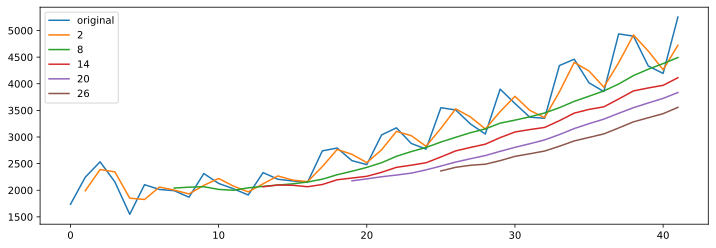

In [56]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(coke_df2['Sales'], label="original") 
for i in range(2,30,6):
    ax.plot(coke_df2['Sales'].rolling(i).mean(), label=str(i))
ax.legend(loc='best')
plt.show()

**Observations**: None of the curves touvh the end of the original curve, thus moving average is a bad choice for forecasting the sales for the given dataset.

#### 5.1.2 Simple exponential smoothing model

In [57]:
test_start = 33 # Start time in test data
test_end = 42 # end time in test data

In [59]:
# forcast -  based on current time
ses_model = SimpleExpSmoothing(train_data["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = test_start,end = test_end )

pred_ses.reset_index(inplace=True, drop=True)
pred_ses.index = test_data.index

ses_mape=mean_absolute_percentage_error(pred_ses,test_data['Sales'])*100 
print("MAPE for simple exp smoothing: {:.3f}".format(ses_mape))

MAPE for simple exp smoothing: 31.442


#### 5.1.3 Holt model

In [60]:
# forcast - based on current time, trend
hw_model = Holt(train_data["Sales"]).fit(smoothing_level=0.8, smoothing_slope=0.2) # two levels of smoothening
pred_hw = hw_model.predict(start = test_start,end = test_end )

pred_hw.reset_index(inplace=True, drop=True)
pred_hw.index = test_data.index

hw_mape=mean_absolute_percentage_error(pred_hw,test_data['Sales'])*100
print("MAPE for Holt model: {:.3f}".format(hw_mape))

MAPE for Holt model: 20.375


#### 5.1.4 Holt winter exponential smoothing with multiplicative seasonality and additive trend.

In [61]:
# forcast - based on current time, trend, seasonality
hwe_model_mul_add = ExponentialSmoothing(train_data["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test_start ,end = test_end )

pred_hwe_mul_add.reset_index(inplace=True, drop=True)
pred_hwe_mul_add.index = test_data.index

hw_ma_mape=mean_absolute_percentage_error(pred_hwe_mul_add,test_data['Sales'])*100 
print("MAPE for HW exp smoothing with mul seasonality and add trend model: {:.3f}".format(hw_ma_mape))


MAPE for HW exp smoothing with mul seasonality and add trend model: 14.733


#### 5.1.5 Holt winter exponential smoothing with additive seasonality and multiplicative trend.

In [62]:
# forcast - based on current time, trend, seasonality
hwe_model_add_mul = ExponentialSmoothing(train_data["Sales"],seasonal="add",trend="mul",seasonal_periods=12).fit() 
pred_hwe_add_mul = hwe_model_add_mul.predict(start = test_start ,end = test_end )

pred_hwe_add_mul.reset_index(inplace=True, drop=True)
pred_hwe_add_mul.index = test_data.index

hw_am_mape=mean_absolute_percentage_error(pred_hwe_add_mul,test_data['Sales'])*100 
print("MAPE for HW exp smoothing with add seasonality and mul trend model: {:.3f}".format(hw_am_mape))


MAPE for HW exp smoothing with add seasonality and mul trend model: 12.287


#### 5.1.6 Holt winter exponential smoothing with additive seasonality and additive trend.

In [63]:
hwe_model_add_add = ExponentialSmoothing(train_data["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test_start ,end = test_end )

pred_hwe_add_add.reset_index(inplace=True, drop=True)
pred_hwe_add_add.index = test_data.index

hw_aa_mape=mean_absolute_percentage_error(pred_hwe_add_add,test_data['Sales'])*100 
print("MAPE for HW exp smoothing with add seasonality and add trend model: {:.3f}".format(hw_aa_mape))

MAPE for HW exp smoothing with add seasonality and add trend model: 15.244


In [64]:
summary_ddf = {'Model MAPE':pd.Series(['se smoothing', 'Holt model', 'HW ma', 'HW am', 'HW aa']),
           'MAPE values':pd.Series([ses_mape, hw_mape, hw_ma_mape, hw_am_mape, hw_aa_mape])}
table_mape_ddf = pd.DataFrame(summary_ddf).sort_values(['MAPE values']).reset_index(drop=True)

In [65]:
table_mape_ddf

,Model MAPE,MAPE values
0,HW am,12.287203
1,HW ma,14.733020
2,HW aa,15.244369
3,Holt model,20.375175
4,se smoothing,31.442413


Holt winter exponential smoothing with additive seasonality and multiplicative trend has the least MAPE. We will use it for forecasting.

#### 5.1.7 Final model using smoothing based forecasting techniques.

In [66]:
hw_am_model = ExponentialSmoothing(train_data["Sales"],seasonal="add",trend="mul",seasonal_periods=12).fit()

test_data2 = test_data.copy() # To use for predictions
test_data2 = test_data2.drop(['Sales', 'log_Sales'], axis=1)
preds_am_model = pd.Series(hw_am_model.predict(start = test_start ,end = test_end ), name='F_Sales')

preds_am_model.reset_index(inplace=True, drop=True)
preds_am_model.index = test_data.index


In [67]:
test_data2 = pd.concat([test_data2, preds_am_model], axis=1, )

In [68]:
test_data2.head()

,Quarter,Q,year,t,t_square,Q1,Q2,Q3,Q4,F_Sales
32,Q1_94,Q1,1994,33,1089,1,0,0,0,3985.188523
33,Q2_94,Q2,1994,34,1156,0,1,0,0,4020.887661
34,Q3_94,Q3,1994,35,1225,0,0,1,0,3795.103141
35,Q4_94,Q4,1994,36,1296,0,0,0,1,3723.784999
36,Q1_95,Q1,1995,37,1369,1,0,0,0,4388.169541


#### 5.1.8 Visualizing the predictions (smoothing based forecasting)

In [69]:
train_data2 = train_data.copy() # To use for visualizations
coke_forecast_ddf = pd.concat([train_data2, test_data2], axis=0)

In [70]:
coke_forecast_ddf.tail()

,Quarter,Sales,log_Sales,Q,year,t,t_square,Q1,Q2,Q3,Q4,F_Sales
37,Q2_95,NaN,NaN,Q2,1995,38,1444,0,1,0,0,4369.546694
38,Q3_95,NaN,NaN,Q3,1995,39,1521,0,0,1,0,4219.953348
39,Q4_95,NaN,NaN,Q4,1995,40,1600,0,0,0,1,4082.051105
40,Q1_96,NaN,NaN,Q1,1996,41,1681,1,0,0,0,4819.968292
41,Q2_96,NaN,NaN,Q2,1996,42,1764,0,1,0,0,4635.983124


In [71]:
coke_forecast_vis_ddf = coke_forecast_ddf[['Sales', 'F_Sales']]

In [72]:
coke_forecast_vis_ddf.tail()

,Sales,F_Sales
37,NaN,4369.546694
38,NaN,4219.953348
39,NaN,4082.051105
40,NaN,4819.968292
41,NaN,4635.983124


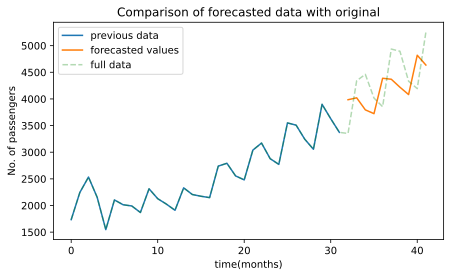

In [73]:
fig, ax = plt.subplots()
ax.plot(coke_forecast_vis_ddf, label=['previous data','forecasted values'])
ax.plot(range(len(coke_forecast_vis_ddf)), coke_df2['Sales'], 'g--', label='full data', alpha=0.3)
ax.set_xlabel('time(months)')
ax.set_ylabel('No. of passengers')
ax.set_title('Comparison of forecasted data with original')
ax.legend()
plt.show()

**Observations** The forecasted values are much closer to the actual values compared to values fron the previous model. The chosen model is doing a good job in following the trend.

### 5.2 ARM, ARMA ARIMA and SARIMA models

###  ACF and PACF plots
ACF: plot between lags and values of correlation

PACF - partial auto-correlation function, plot between lags and residuals 
(Instead of finding correlations of present with lags like ACF, it finds correlations between the residuals)

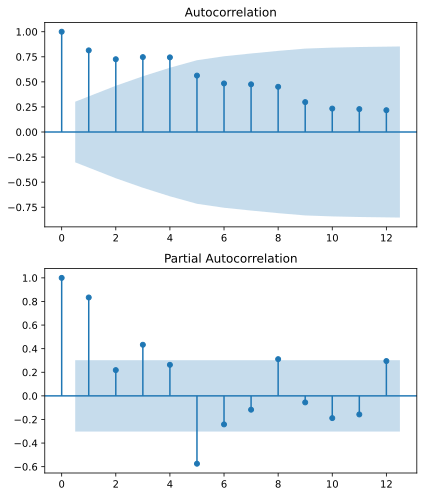

In [74]:
fig, ax = plt.subplots(2,1, figsize=(6,7))
tsa_plots.plot_acf(coke_df2['Sales'], lags=12, ax=ax[0])
tsa_plots.plot_pacf(coke_df2['Sales'], lags=12, ax=ax[1])
fig.tight_layout()
plt.show()

#### 5.2.2 ARMA

In [75]:
ARMAmodel = ARMA(train_data['Sales'], order=(3, 0)) #model with AR=3 and MA=0
ARMAmodel_fit = ARMAmodel.fit()

ARMA_pred = ARMAmodel_fit.predict(start = 32 ,end = 41 )
ARMA_pred

arma_mape=mean_absolute_percentage_error(ARMA_pred,test_data['Sales'])*100 
arma_mape

28.120052065406497

#### 5.2.3 ARIMA

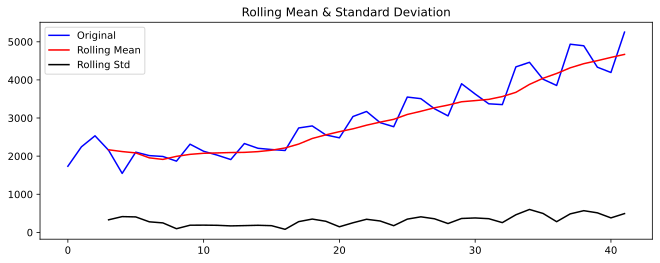

In [76]:
#  visualizing the trend/ stationary nature of data - for ARIMA model
rolLmean = coke_df2['Sales'].rolling(4).mean() # 12 entries
rolLstd = coke_df2['Sales'].rolling(4).std()

fig, ax = plt.subplots(figsize=(11,4))

#Plot rolling statistics:
orig = ax.plot(coke_df2['Sales'], color='blue',label='Original')
mean = ax.plot(rolLmean, color='red', label='Rolling Mean')
std = ax.plot(rolLstd, color='black', label = 'Rolling Std')
ax.legend(loc='best')
ax.set_title('Rolling Mean & Standard Deviation')
plt.show(block=False)

**Observations:** The data is not stationary, hence we cannot use ARMA and need to make it stationary and apply ARIMA.

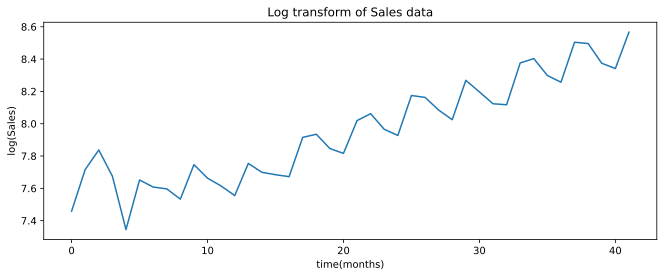

In [77]:
# Log transform 
fig, ax = plt.subplots(figsize=(11,4))

ts_log = np.log(coke_df2['Sales'])#to transform to stationary from non-stationary
ax.plot(ts_log)
ax.set_title('Log transform of Sales data')
ax.set_xlabel('time(months)')
ax.set_ylabel('log(Sales)')
plt.show()

**Observations:** Log transform is not able to make the data linear.

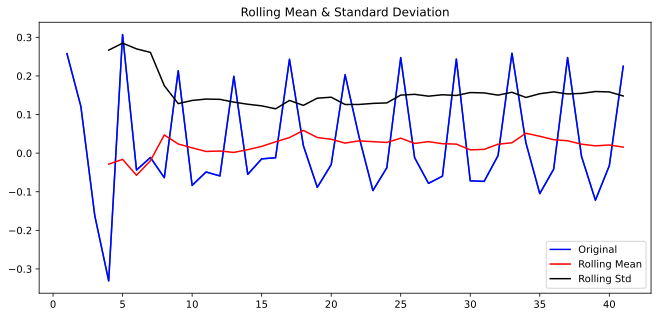

In [78]:
#  Differencing
fig, ax = plt.subplots(figsize=(11,5))

ts_log_diff = ts_log - ts_log.shift(periods=1) # shift the time series by 1 and subtract from the original TS.
ax.plot(ts_log_diff)

#Determing rolling statistics
rolLmean = ts_log_diff.rolling(4).mean()
rolLstd = ts_log_diff.rolling(4).std()

#Plot rolling statistics:
orig = plt.plot(ts_log_diff, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
ax.legend(loc='best')
ax.set_title('Rolling Mean & Standard Deviation')
plt.show(block=False)

**Observations** The rolling maean line is not stationary, hence it ARIMA may not perform well for forecasting on CocaCola sales data.

### 5.2.4 SARIMA

In [79]:
model=sm.tsa.statespace.SARIMAX(train_data['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,3))
results=model.fit()

In [80]:
preds_sarima = results.predict(start = test_start , end = test_end , dynamic=True)

preds_sarima.reset_index(inplace=True, drop=True)
preds_sarima.index = test_data.index

sarima_mape = mean_absolute_percentage_error(preds_sarima, test_data['Sales'])*100 

In [81]:
print("MAPE for SARIMA model: {:.3f}".format(sarima_mape))

MAPE for SARIMA model: 14.791


#### Observations:
Of all the ARMA and SARIMA models, SARIMA has the least MAPE, but this is sill slightly higher than the Holt's Winter additive seasonality and multiplicative trend.

## 6. Final model
- Based on the above analysis, we can choose **Holt's Winter additive seasonality and multiplicative trend since it has the lowest MAPE of all models**.

### 6.1 Constructing a new dataset for the subsequent year

In [82]:
coke_df_new = pd.DataFrame()

In [83]:
quarters_new = ['Q3_96', 'Q4_96', 'Q1_97', 'Q2_97', 'Q3_97', 'Q4_97'] # Generating the months

In [84]:
quarters_list = pd.Series(data=quarters_new,
                          name='Quarter',
                          dtype='str') # quarters col

In [85]:
coke_df_new = pd.DataFrame(quarters_list)

In [86]:
# Split quarters from the year and put them into separate columns.
coke_df_new[['Q', 'year']] = coke_df_new['Quarter'].str.split('_', expand=True) # Using vectorized str split.

In [87]:
# Add a prefix of '19' to the year column.
coke_df_new['year'] = coke_df_new['year'].apply(lambda x: '19'+ str(x))

In [88]:
# One hot encode the quarters.
quarters1 = ['Q1', 'Q2', 'Q3', 'Q4'] #coke_df_new['Q'].unique()

In [89]:
quat_enc_new = pd.get_dummies(coke_df_new['Q']).reindex(columns=quarters1)

In [90]:
quat_enc_new

,Q1,Q2,Q3,Q4
0,0,0,1,0
1,0,0,0,1
2,1,0,0,0
3,0,1,0,0
4,0,0,1,0
5,0,0,0,1


In [91]:
# Creating numeric columns for time (in terms of quarters)
t_array_new = np.linspace(42, 47, num =len(coke_df_new), dtype=int)
t_sq_array_new = t_array_new**2

In [92]:
time_new = {'t': t_array_new,
            't_square':t_sq_array_new}

In [93]:
t_df_new = pd.DataFrame(time_new, index=coke_df_new.index)

In [94]:

coke_df_new = pd.concat([coke_df_new, t_df_new, quat_enc_new], axis=1)

In [95]:
coke_df_new # Prepared dataframe for the subsequent year.

,Quarter,Q,year,t,t_square,Q1,Q2,Q3,Q4
0,Q3_96,Q3,1996,42,1764,0,0,1,0
1,Q4_96,Q4,1996,43,1849,0,0,0,1
2,Q1_97,Q1,1997,44,1936,1,0,0,0
3,Q2_97,Q2,1997,45,2025,0,1,0,0
4,Q3_97,Q3,1997,46,2116,0,0,1,0
5,Q4_97,Q4,1997,47,2209,0,0,0,1


In [96]:
coke_df_test = coke_df_new.copy()

### 6.2 Fitting the final model with full dataset

In [97]:
coke_df2.head()

,Quarter,Sales,log_Sales,Q,year,t,t_square,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,7.458663,Q1,1986,1,1,1,0,0,0
1,Q2_86,2244.960999,7.716443,Q2,1986,2,4,0,1,0,0
2,Q3_86,2533.804993,7.837477,Q3,1986,3,9,0,0,1,0
3,Q4_86,2154.962997,7.675529,Q4,1986,4,16,0,0,0,1
4,Q1_87,1547.818996,7.344602,Q1,1987,5,25,1,0,0,0


In [98]:
final_model = ExponentialSmoothing(coke_df2["Sales"],seasonal="add",trend="mul",seasonal_periods=12).fit()

In [99]:
# Predictions from t=42 to t=47 -Corresponding months for the subsequent year.
df_new = pd.Series(final_model.predict(start=42 ,end = 47), name='F_Sales').reset_index(drop=True)

In [100]:
coke_df_test = pd.concat([coke_df_test, df_new], axis=1)

In [101]:
coke_df_test

,Quarter,Q,year,t,t_square,Q1,Q2,Q3,Q4,F_Sales
0,Q3_96,Q3,1996,42,1764,0,0,1,0,4929.906308
1,Q4_96,Q4,1996,43,1849,0,0,0,1,4768.721074
2,Q1_97,Q1,1997,44,1936,1,0,0,0,4816.560479
3,Q2_97,Q2,1997,45,2025,0,1,0,0,5670.954325
4,Q3_97,Q3,1997,46,2116,0,0,1,0,5693.093556
5,Q4_97,Q4,1997,47,2209,0,0,0,1,5309.772150


### 6.3 Visualizing the final predictions

In [102]:
final_forecast = pd.concat([coke_df2, coke_df_test], axis=0)

In [103]:
final_forecast.tail(14)

,Quarter,Sales,log_Sales,Q,year,t,t_square,Q1,Q2,Q3,Q4,F_Sales
34,Q3_94,4461.0,8.403128,Q3,1994,35,1225,0,0,1,0,NaN
35,Q4_94,4017.0,8.298291,Q4,1994,36,1296,0,0,0,1,NaN
36,Q1_95,3854.0,8.256867,Q1,1995,37,1369,1,0,0,0,NaN
37,Q2_95,4936.0,8.504311,Q2,1995,38,1444,0,1,0,0,NaN
38,Q3_95,4895.0,8.495970,Q3,1995,39,1521,0,0,1,0,NaN
39,Q4_95,4333.0,8.374015,Q4,1995,40,1600,0,0,0,1,NaN
40,Q1_96,4194.0,8.341410,Q1,1996,41,1681,1,0,0,0,NaN
41,Q2_96,5253.0,8.566555,Q2,1996,42,1764,0,1,0,0,NaN
0,Q3_96,NaN,NaN,Q3,1996,42,1764,0,0,1,0,4929.906308
1,Q4_96,NaN,NaN,Q4,1996,43,1849,0,0,0,1,4768.721074


In [104]:
final_forecast_vis = final_forecast[['Sales', 'F_Sales']].reset_index(drop=True)

In [105]:
final_forecast_vis.tail()

,Sales,F_Sales
43,NaN,4768.721074
44,NaN,4816.560479
45,NaN,5670.954325
46,NaN,5693.093556
47,NaN,5309.772150


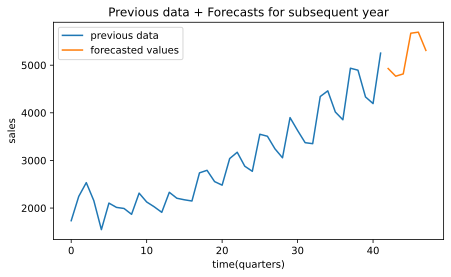

In [106]:
fig, ax = plt.subplots()
ax.plot(final_forecast_vis, label=['previous data','forecasted values'])
ax.set_xlabel('time(quarters)')
ax.set_ylabel('sales')
ax.set_title('Previous data + Forecasts for subsequent year')
ax.legend()
plt.show()

## 7. Conclusion:
- Different model were tried out to forecast the sales for CocaCola and the **Holt's Winter additive seasonality and multiplicative trend**, had the least MAPE. This was chosen as the final model.
- **Note:**A total of **10 dummy variables** were created to aid in the model building process for model based forecasting.
- **Note 2:** The extra columns were added in the final data set for convenience if model based forecasting is to be used. In the present case it is not required.